# **Data**

In [1]:
!pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.utils import pad_sequences,plot_model
from sklearn import model_selection
from sklearn.metrics import classification_report,confusion_matrix
from string import printable
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Model,load_model
from keras import regularizers
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, ELU, LSTM, Embedding, BatchNormalization, Conv1D, MaxPooling1D,GRU,SimpleRNN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from scipy.io.arff import loadarff 
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
%matplotlib inline

In [3]:
df=pd.read_csv('phishing_site_urls.csv')

In [4]:
df.shape

(549346, 2)

In [5]:
df['URL'][1]

'www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php'

In [6]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

In [7]:
df['Label'].value_counts()

Label
good    392924
bad     156422
Name: count, dtype: int64

C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Aaditya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

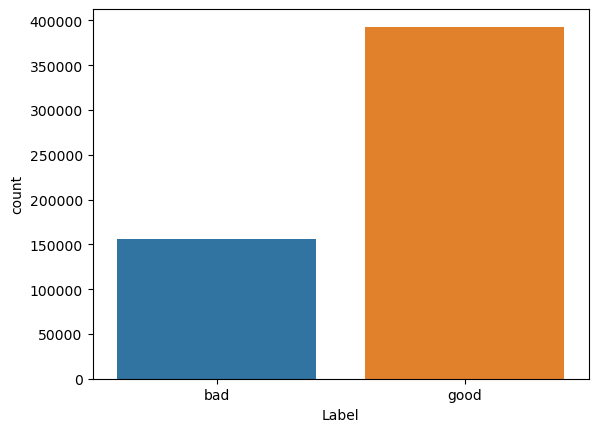

In [8]:
sns.countplot(x='Label', data=df)

In [9]:
df.loc[df["Label"] == 'bad', "Label"] = 0
df.loc[df["Label"] == "good", "Label"] = 1
df.Label.value_counts()

Label
1    392924
0    156422
Name: count, dtype: int64

In [10]:
class_1_indices = np.where(df.Label == 1)[0][:156422]
class_0_indices = np.where(df.Label == 0)[0]

In [11]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0
3,mail.printakid.com/www.online.americanexpress....,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,0


# example preprocessing

In [12]:
character_encoding=[printable.index(x) + 1 for x in printable]
for x in range(0,len(character_encoding)):
  print(printable[x],"=",character_encoding[x],"\n")

0 = 1 

1 = 2 

2 = 3 

3 = 4 

4 = 5 

5 = 6 

6 = 7 

7 = 8 

8 = 9 

9 = 10 

a = 11 

b = 12 

c = 13 

d = 14 

e = 15 

f = 16 

g = 17 

h = 18 

i = 19 

j = 20 

k = 21 

l = 22 

m = 23 

n = 24 

o = 25 

p = 26 

q = 27 

r = 28 

s = 29 

t = 30 

u = 31 

v = 32 

w = 33 

x = 34 

y = 35 

z = 36 

A = 37 

B = 38 

C = 39 

D = 40 

E = 41 

F = 42 

G = 43 

H = 44 

I = 45 

J = 46 

K = 47 

L = 48 

M = 49 

N = 50 

O = 51 

P = 52 

Q = 53 

R = 54 

S = 55 

T = 56 

U = 57 

V = 58 

W = 59 

X = 60 

Y = 61 

Z = 62 

! = 63 

" = 64 

# = 65 

$ = 66 

% = 67 

& = 68 

' = 69 

( = 70 

) = 71 

* = 72 

+ = 73 

, = 74 

- = 75 

. = 76 

/ = 77 

: = 78 

; = 79 

< = 80 

= = 81 

> = 82 

? = 83 

@ = 84 

[ = 85 

\ = 86 

] = 87 

^ = 88 

_ = 89 

` = 90 

{ = 91 

| = 92 

} = 93 

~ = 94 

  = 95 

	 = 96 


 = 97 

 = 98 

 = 99 

 = 100 



In [13]:
url='https://www.apple.com/'
encoded=[printable.index(x) + 1 for x in url if x in printable]
print(encoded)

[18, 30, 30, 26, 29, 78, 77, 77, 33, 33, 33, 76, 11, 26, 26, 22, 15, 76, 13, 25, 23, 77]


# **Pre-processing**

In [14]:
#1) encoding the characters in URL from 1 to 100, using nested list comprehension.
url_encoded = [[printable.index(x) + 1 for x in url if x in printable] for url in df.URL]

In [15]:
#2)Length normalization, The length of all URL's normalized at fixed length, if the (url length< fixed length) zeroes are added at front of the url,
# if the (url length> fixed length) the etra character are intercepted from the end
max_len=75
X = pad_sequences(url_encoded, maxlen=max_len, truncating='post')

In [16]:
X = np.concatenate((X[class_1_indices], X[class_0_indices[:156422]]))

In [17]:
X.shape

(312844, 75)

In [18]:
X

array([[15, 29, 34, ..., 14, 98, 20],
       [33, 33, 33, ..., 62, 55, 96],
       [69, 33, 33, ..., 26, 22, 67],
       ...,
       [ 0,  0,  0, ..., 28, 17, 77],
       [ 0,  0,  0, ..., 28, 17, 77],
       [ 0,  0,  0, ..., 24, 16, 25]])

In [19]:
y = np.array(df.Label)

In [20]:
y = np.concatenate((y[class_1_indices], y[class_0_indices[:156422]]))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [23]:
# Define hyperparameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

In [24]:
# Train the LightGBM model
num_round = 1000  # Number of boosting rounds
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

In [25]:
# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

In [26]:
y_pred

array([0.12393047, 0.01388597, 0.01951732, ..., 0.82823627, 0.91276895,
       0.99416065])

In [27]:
# Convert probabilities to binary predictions
y_pred_binary = (y_pred >= 0.5).astype(int)

In [28]:
# Evaluate the model
accuracy = accuracy_score(y_test.astype(int), y_pred_binary)
roc_auc = roc_auc_score(y_test.astype(int), y_pred)

In [29]:
accuracy

0.9224695935687002

In [30]:
roc_auc

0.9757329753801482

In [31]:
cm=confusion_matrix(y_test.astype(int), y_pred_binary)
cm

array([[28341,  2996],
       [ 1855, 29377]], dtype=int64)

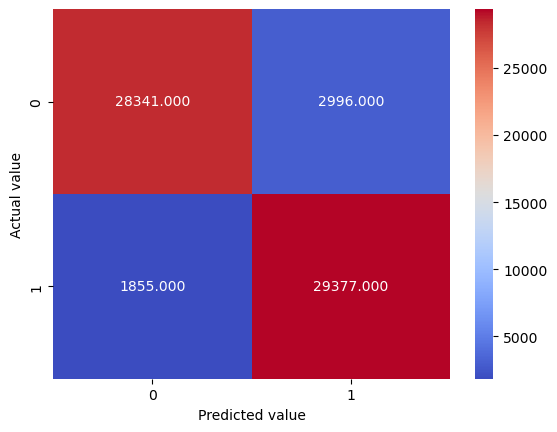

In [33]:
sns.heatmap(cm, annot=True, cmap='coolwarm',fmt='0.3f')
plt.ylabel("Actual value")
plt.xlabel("Predicted value")
plt.show()

In [34]:
accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
accuracy

0.9224695935687002

In [35]:
print(classification_report(y_test.astype(int),y_pred_binary))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     31337
           1       0.91      0.94      0.92     31232

    accuracy                           0.92     62569
   macro avg       0.92      0.92      0.92     62569
weighted avg       0.92      0.92      0.92     62569



# ***TESTING***

In [48]:
test_url='https://www.youtube.com/subscriptions'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')

In [49]:
# Make predictions
y_predicted = bst.predict(encoded_url, num_iteration=bst.best_iteration)

In [50]:
y_predicted

array([0.88449121])

In [ ]:
if y_predicted>=0.5:
    print(1)
else:
    print(0)

In [ ]:
test_url='website.com/paypal.com/enterspages.com/QC/St-Leonard-apartment.html'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')
cnn_gru_model.predict(encoded_url,batch_size=1)

In [55]:
test_url='website.com/paypal.com/St-Leonard-apartment.html'
encoded_url=[[printable.index(x) + 1 for x in test_url if x in printable]]
max_len=75
encoded_url = np.asarray(encoded_url).astype(np.float32)
encoded_url = pad_sequences(encoded_url, maxlen=max_len, truncating='post')

In [56]:
y_prediction_2 = bst.predict(encoded_url, num_iteration=bst.best_iteration)
y_prediction_2

array([0.61470536])